## Idea - Model

<img src="./img/guided_sampling_score_function.jpg" alt="image" width="50%" height="auto">


## Idea - modified Unet

기존 `Unet`에서 conditioning variable을 받아야 한다. MNIST label을 이용하면 0 ~ 9까지 conditioning variable이 나오는데, 이거를 $t$ embedding 처럼 망에 집어넣는거다. 

기존 `Unet`은 $t$ embedding을 `ResNetBlock`에서 받아서 처리했는데, 두번 받아서 처리하니까, 두번째 `ResNetBlock`에서는 conditioning variable을 embedding한 값으로 받아서 처리하도록 하면 될 거 같음.

```python
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t) # implement conditioning variable embedding at here
            x = attn(x)
            h.append(x)

            x = downsample(x)
```

이 사항을 일단 `GuidedUnet`에 반영했다. 

In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from Unet import *
from DiffusionModel import *
from GuidedUnet import *

In [2]:
# define hyperparameters

image_size = 32
channel = 1

batchsize = 128

timestep = 300

lr = 1e-3
epochs = 5

delta = 0.5

condition_shift = timestep + 100

dimmults = (1,2,4,8)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cuda:0


In [3]:
# get MNIST datasets

data_root = './data'

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])

train_set = datasets.MNIST(
    root=data_root, train=True, download=True, transform=transform
)

data_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)

In [4]:
# define linear beta schedule

linear_betas, linear_alphas, linear_sqrt_alphas, linear_sqrt_one_minus_alphas, linear_sampling_1, linear_sampling_2 = total_beta_schedule(linear_beta_schedule, timestep)

# define linear network and optimizer_linear

linear_net = GuidedUnet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
linear_net.to(device)

linear_optimizer = optim.Adam(linear_net.parameters(), lr=lr)

In [5]:
# train - linear

linear_training_loss, linear_training_taken_step, linear_taken_step = training_guided(data_loader, 
                                                                                      epochs, 
                                                                                      timestep, 
                                                                                      linear_net, 
                                                                                      linear_optimizer, 
                                                                                      device,
                                                                                      linear_sqrt_alphas, 
                                                                                      linear_sqrt_one_minus_alphas, 
                                                                                      condition_shift)


>> epoch : 0 / with condition variable


c:\Users\saych\OneDrive\document\usurf\diffusion\DiffusionModel.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(labels, device=device) + condition_shift


Loss:  0.06510704755783081
Loss:  0.040250666439533234
Loss:  0.043331071734428406
Loss:  0.042443372309207916
>> epoch : 1 / with condition variable
Loss:  0.04121289402246475
Loss:  0.03402561694383621
Loss:  0.04071161895990372
Loss:  0.03225981816649437
Loss:  0.03302328288555145
>> epoch : 2 / with condition variable
Loss:  0.034366898238658905
Loss:  0.02793576754629612
Loss:  0.02744395285844803
Loss:  0.029152216389775276
Loss:  0.03279329091310501
>> epoch : 3 / with condition variable
Loss:  0.026742488145828247
Loss:  0.02451784722507
Loss:  0.03268999233841896
Loss:  0.028152193874120712
>> epoch : 4 / with condition variable
Loss:  0.029240190982818604
Loss:  0.033514805138111115
Loss:  0.025796664878726006
Loss:  0.023564282804727554
Loss:  0.02768028900027275
training without conditioning variable
Loss:  0.03067605011165142
Loss:  0.032673753798007965
Loss:  0.026294492185115814
Loss:  0.02588367834687233
Loss:  0.02732042409479618


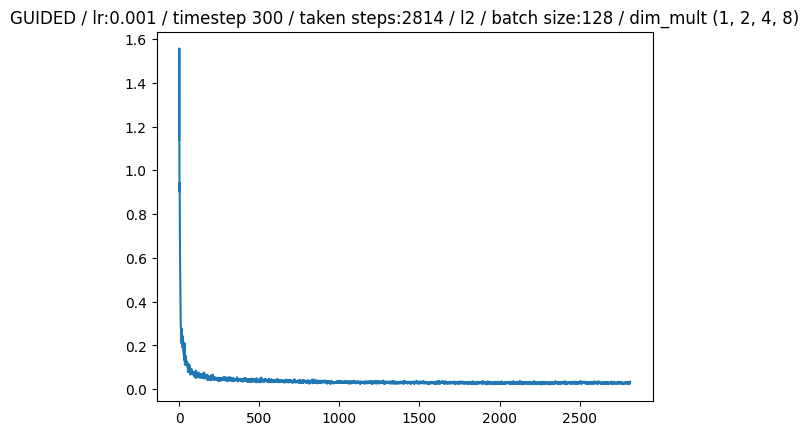

In [6]:
# plot loss linear 

x = np.array(linear_training_taken_step)
y = np.array([x.cpu().detach().numpy() for x in linear_training_loss])

plt.plot(x, y)
plt.title(f"GUIDED / lr:{lr} / timestep {timestep} / taken steps:{linear_taken_step} / l2 / batch size:{batchsize} / dim_mult {dimmults}")
plt.show()

In [7]:
# save linear model
save_net_betas(linear_net, 
               linear_betas, 
               linear_alphas,
               linear_sqrt_alphas,
               linear_sqrt_one_minus_alphas,
               linear_sampling_1, 
               linear_sampling_2, 
               "linear_guided")